**This notebook is for sgRNA denoising in CROPseq experiment.**

Import packages
==

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted, ns
import scanpy as sc
import numba
import anndata as ad
from sklearn.metrics import r2_score
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.5 umap==0.4.6 numpy==1.21.4 scipy==1.6.2 pandas==1.3.2 scikit-learn==1.0.1 statsmodels==0.12.1 python-igraph==0.9.1 louvain==0.6.1 leidenalg==0.8.3


In [3]:
import spreen as sn

Plot setting
==

In [4]:
#publication quality plots
from matplotlib import pylab

params = {'legend.fontsize': 5,
          'figure.facecolor':"w",
          'figure.figsize': (3, 2),
          'axes.labelsize': 6,
          'axes.titlesize': 6,
         'axes.linewidth': 0.5,
         'xtick.labelsize': 5,
         'ytick.labelsize': 5,
          # set tick width
          'xtick.major.size': 3.5,
          'xtick.major.width': 0.5,
          'xtick.minor.size': 2,
          'xtick.minor.width': 0.5,
          'xtick.color': 'black',
          'ytick.major.size': 3.5,
          'ytick.major.width': 0.5,
          'ytick.minor.size': 2,
          'ytick.minor.width': 0.5,
          'ytick.color': 'black',
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":200}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10});
pylab.rc('font',**{'family':'sans-serif','sans-serif':['Arial'], 'size':6})

# Set the font used for MathJax - more on this later
# pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 600x400 with 0 Axes>

In [5]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
from matplotlib import rcParams
import umap
rcParams['figure.figsize'] = 3, 3

scanpy==1.8.1 anndata==0.7.5 umap==0.4.6 numpy==1.21.4 scipy==1.6.2 pandas==1.3.2 scikit-learn==1.0.1 statsmodels==0.12.1 python-igraph==0.9.1 louvain==0.6.1 leidenalg==0.8.3


10x 10k_PBMCs dataset
---

In [6]:
indir_10k = "/da/onc/bfx/research/shengca1/public_data/10xgenomics/10k_PBMCs_TotalSeq_B_3p"
adata_10k = sc.read_10x_mtx(indir_10k+'/filtered_feature_bc_matrix', gex_only=True)
adata_10k.obs['batch'] = '10k'

10x 5k_PBMC dataset
---

In [7]:
indir = "/da/onc/bfx/research/shengca1/public_data/10xgenomics/5k_pbmc_protein_v3/"
adata_5k = sc.read_10x_mtx(indir+'/filtered_feature_bc_matrix', gex_only=True)
adata_5k.obs['batch'] = '5k'

## combine two datasets

In [8]:
adata = ad.AnnData.concatenate(*[adata_5k, adata_10k], batch_key='batch')

In [29]:
def process_adata(adata, min_genes=200, min_counts = 1500, min_cells=3, resolution=1, random_state=8):

    adata_out = adata.copy()

    sc.pp.calculate_qc_metrics(adata_out, inplace=True)
    mito_genes = adata_out.var_names.str.startswith("MT-")
    adata_out.obs["percent_mito"] = adata_out[:,adata_out.var_names.str.startswith("MT-")].X.A.sum(axis=1) / adata_out.obs['total_counts'].values

    sc.pp.filter_genes(adata_out, min_cells=min_cells)
    
    # Filter cells by min_genes
    sc.pp.filter_cells(adata_out, min_genes=min_genes) #200
    adata_out = adata_out[adata_out.obs["n_genes_by_counts"] < 5000, :]

    # Filter cells by mitochondrial reads, n_genes, n_counts

    adata_out = adata_out[adata_out.obs["percent_mito"] < 0.2, :]
    adata_out = adata_out[adata_out.obs["total_counts"] < 15000, :]
    adata_out = adata_out[adata_out.obs["total_counts"] > min_counts, :] # 1500

    sc.pp.normalize_total(adata_out, target_sum=1e4)
    sc.pp.log1p(adata_out)  # log normalization works well for this dataset
    
    sc.pp.highly_variable_genes(adata_out, min_mean=0.02, max_mean=4, min_disp=0.5)
    sc.pp.scale(adata_out, max_value=10)
    sc.tl.pca(adata_out, svd_solver='arpack', random_state=random_state)
    sc.pp.neighbors(adata_out, n_neighbors=15, n_pcs=25, random_state=random_state)
    sc.tl.leiden(adata_out, key_added='leiden_clusters', resolution=resolution, random_state=random_state)
    sc.tl.umap(adata_out, random_state=random_state)

    return adata_out

In [30]:
adata_processed = process_adata(adata);

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
adata_processed.obs['batch'] = adata_processed.obs['batch'].cat.rename_categories(['PBMCs_5k', 'PBMCs_10k'])

... storing 'feature_types' as categorical
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


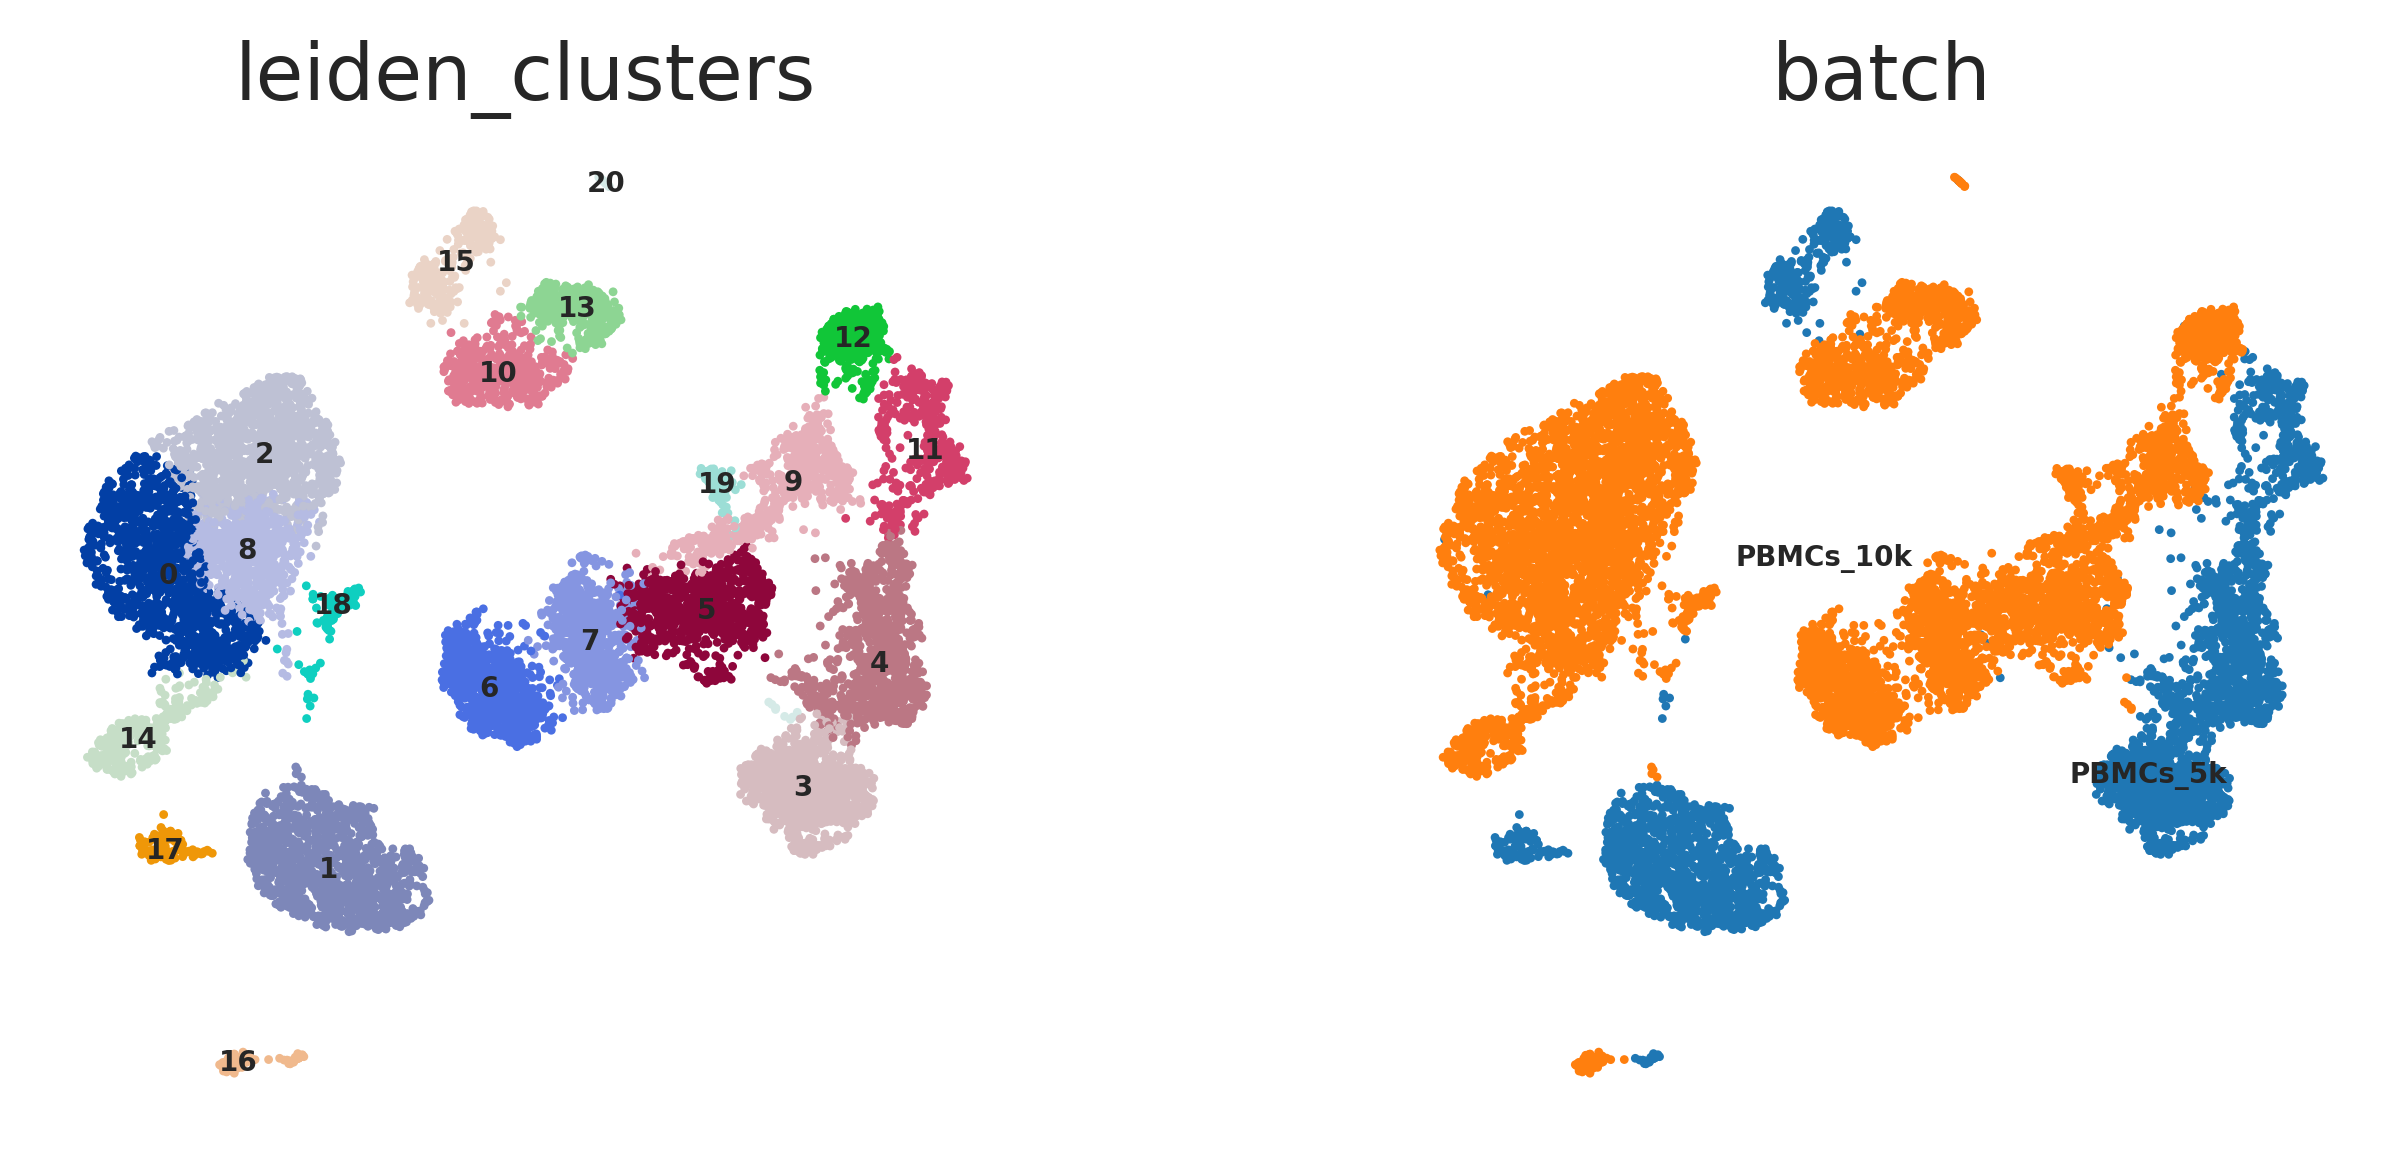

In [32]:
sc.settings.set_figure_params(dpi=200,figsize=(3, 3.2))
ax = sc.pl.umap(adata_processed, size=10, color=["leiden_clusters", 'batch'],
                frameon=False,
                legend_loc="on data", legend_fontsize=5,
                vmax=3, vmin=0, return_fig=True)

## Denoised counts

In [41]:
denoised_5k = pd.read_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/scAR_out_mRNA/expected_natives.pickle')
denoised_10k = pd.read_pickle('/da/ONC/BFx/research/shengca1/pipeline/ods-scar/CITEseq/10k_PBMCs_TotalSeq_B_3p/scAR_out_mRNA/expected_natives.pickle')

In [42]:
denoised_5k

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AAACCCAAGAGACAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCCTAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTCGTGCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCGTGCATA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGACAAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCAGTCTTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATGGCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATTGCCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
adata_5k.to_df()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AAACCCAAGAGACAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCCTAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTCGTGCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCGTGCATA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGACAAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCAGTCTTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATGGCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATTGCCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
adata.to_df()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.1,AC007325.4,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC233755.2,AC233755.1,AC240274.1,AC213203.1
AAACCCAAGAGACAAG-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCCTAGA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTCGTGCCA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCGTGCATA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGACAAGCC-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTAAACC-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATAGTCGT-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCCGTACGG-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCGAGGCAA-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
denoised = denoised_5k[adata.var_names].append(denoised_10k[adata.var_names])

In [48]:
import umap
reducer = umap.UMAP()

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
scaled_penguin_data = StandardScaler().fit_transform(denoised.values)

In [51]:
scaled_penguin_data

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
embedding = reducer.fit_transform(scaled_penguin_data)

In [43]:
from scipy.sparse import csr_matrix

adata_5k_denoised = adata_5k.copy()
adata_5k_denoised.X = csr_matrix(denoised_5k.loc[:,adata_5k.var_names].values)
adata_5k_denoised.obs['batch'] = '5k'

adata_10k_denoised = adata_10k.copy()
adata_10k_denoised.X = csr_matrix(denoised_10k.loc[:,adata_10k.var_names].values)
adata_10k_denoised.obs['batch'] = '10k'

In [44]:
adata_denoised = ad.AnnData.concatenate(*[adata_5k_denoised, adata_10k_denoised], batch_key='batch')
adata_denoised.obs['batch'] = adata_denoised.obs['batch'].cat.rename_categories(['PBMCs_5k', 'PBMCs_10k'])

In [45]:
adata_denoised = adata_denoised[adata_processed.obs_names]
adata_denoised = adata_denoised[:,adata_processed.var_names]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [46]:
random_state=8
adata_out = adata_denoised.copy()
sc.pp.calculate_qc_metrics(adata_out, inplace=True)

sc.pp.normalize_total(adata_out, target_sum=1e4)
sc.pp.log1p(adata_out)  # log normalization works well for this dataset

# sc.pp.highly_variable_genes(adata_out, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.scale(adata_out, max_value=8)
sc.tl.pca(adata_out, svd_solver='arpack', random_state=random_state)
sc.pp.neighbors(adata_out, n_neighbors=15, n_pcs=25, random_state=random_state)

In [47]:
sc.tl.leiden(adata_out, key_added='leiden_clusters', resolution=1, random_state=random_state)
sc.tl.umap(adata_out, random_state=random_state)

... storing 'feature_types' as categorical
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


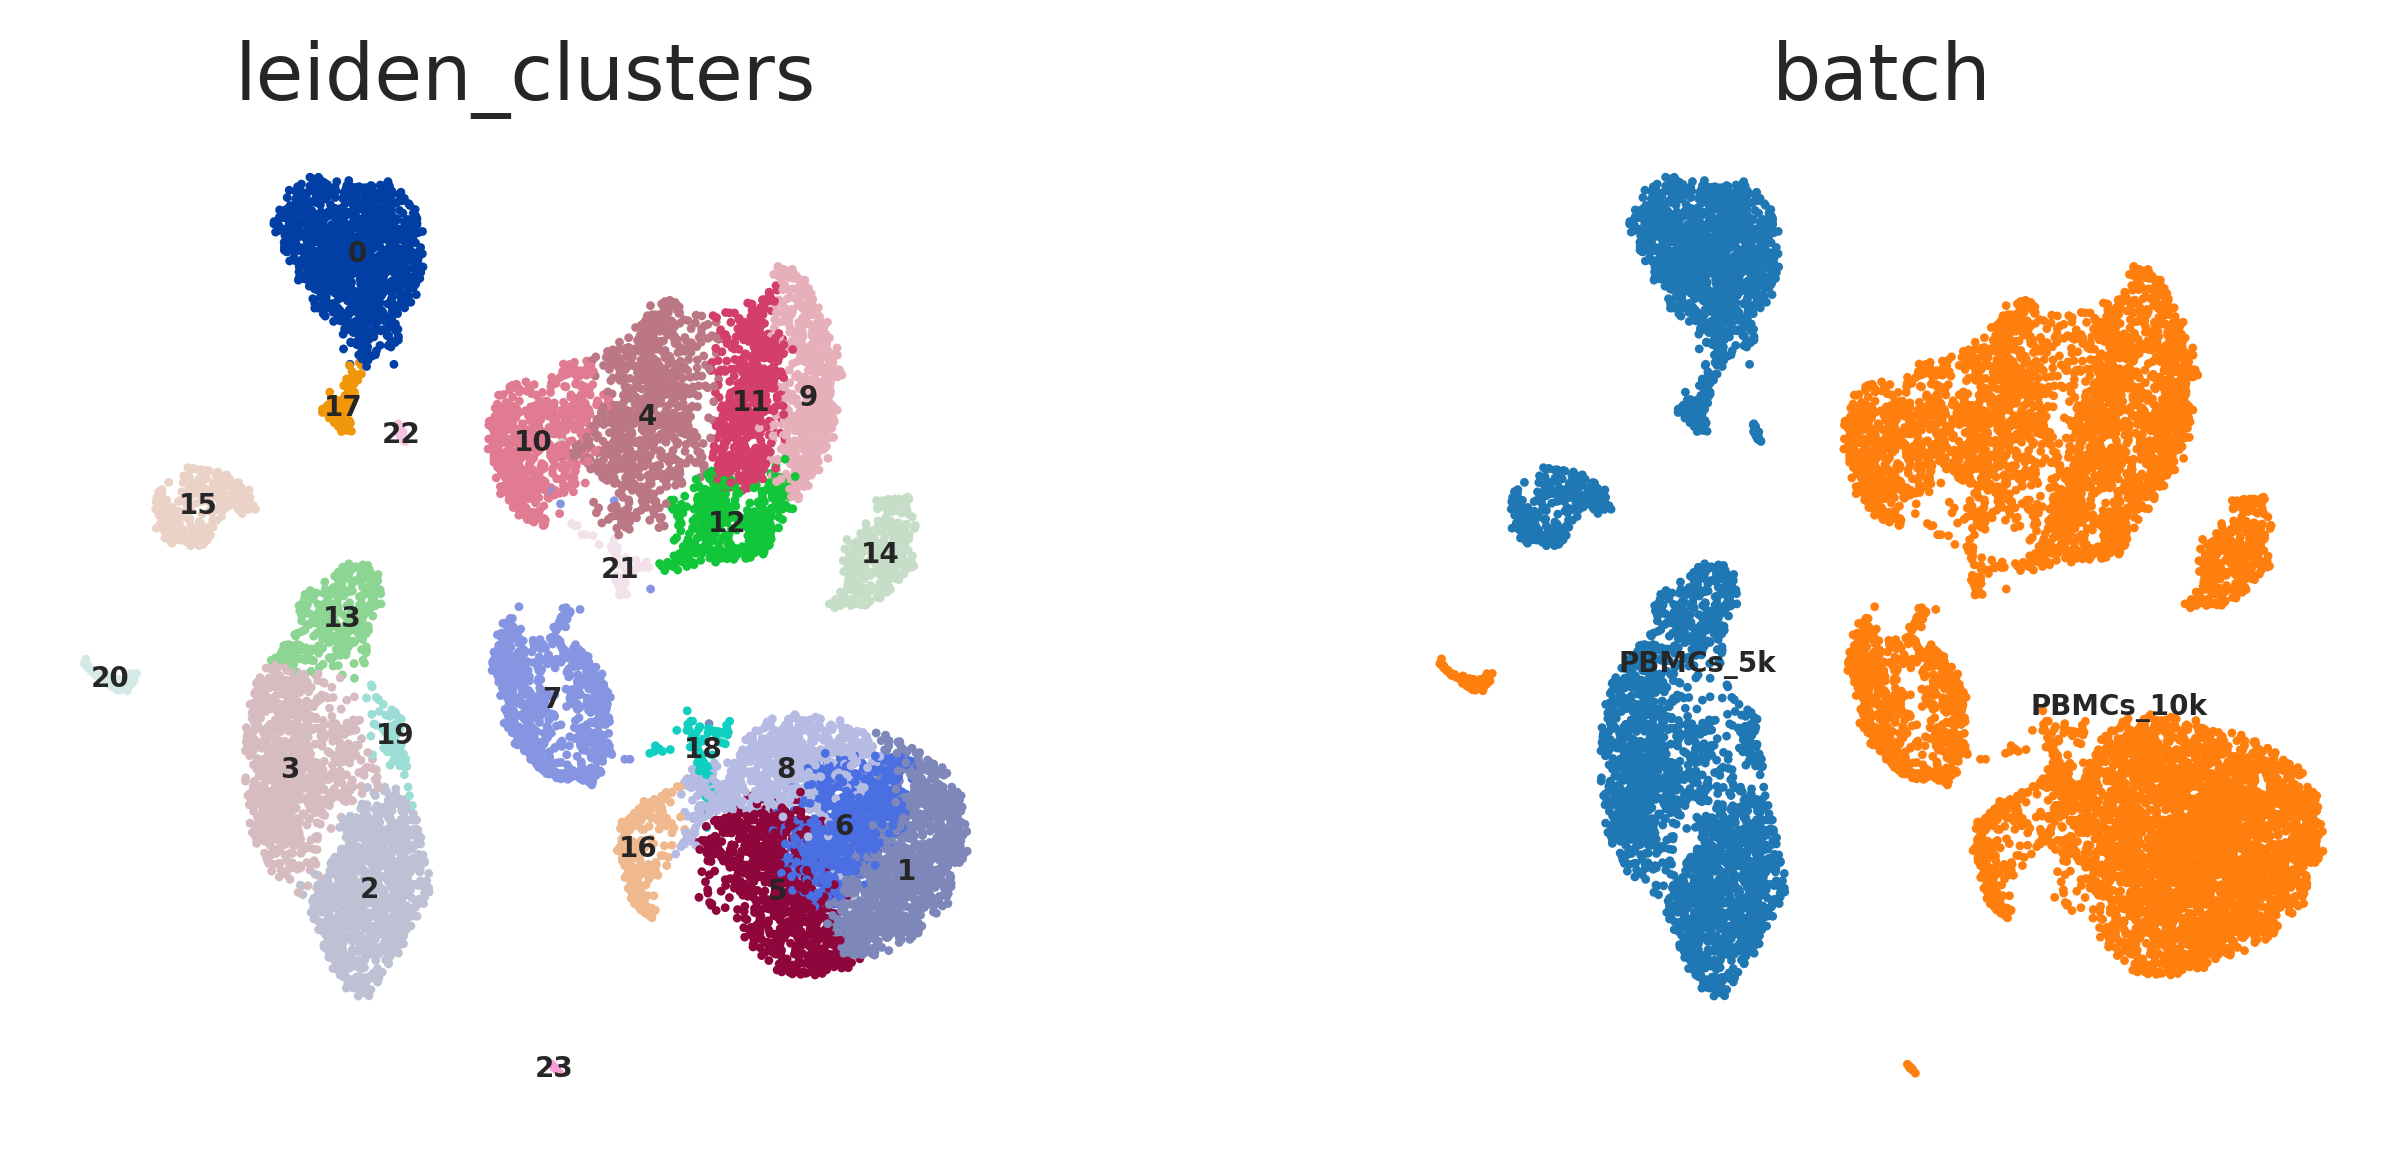

In [48]:
sc.settings.set_figure_params(dpi=200,figsize=(3, 3.2))
ax = sc.pl.umap(adata_out, size=10, color=["leiden_clusters", 'batch'],
                frameon=False,
                legend_loc="on data", legend_fontsize=5,
                vmax=3, vmin=0, return_fig=True)

### Take the same cells

In [36]:
denoised_5k.index = denoised_5k.index.astype(str)+'-0'
denoised_10k.index = denoised_10k.index.astype(str)+'-1'

In [28]:
denoised_combined = denoised_5k.append(denoised_10k)

In [ ]:
denoised_adata = ad.

In [30]:
adata

AnnData object with n_obs × n_vars = 14520 × 31915
    obs: 'batch'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1'

In [29]:
denoised_combined

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC244213.1,AC011751.1,AC007244.1,AC010889.2,AC009494.2,AC010086.3,AC024236.1,PRYP3,AC213203.2,AC004556.3
AAACCCAAGAGACAAG-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGGCCTAGA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAGTCGTGCCA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCATCGTGCATA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGAAAGACAAGCC-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTAAACC-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATAGTCGT-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCCGTACGG-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGTCGAGGCAA-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
sc.tl.rank_genes_groups(adata_processed, 'leiden_clusters', method='t-test_overestim_var')

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [17]:
result = adata_processed.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(20)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,RPL32,2.607190e-233,IL7R,4.426037e-174,S100A8,5.337718e-317,CCL5,3.030579e-201,CST3,6.794805e-131,GNLY,1.369006e-151,TYMP,3.397208e-57,CD79A,5.209252e-110,IGHM,5.539389e-147,GNLY,9.038054e-89,FCGR3A,1.686152e-73,CD8B,4.955468e-22,IL32,4.128220e-14,LYZ,4.090137e-09,IL3RA,4.003152e-31
1,RPS3A,2.956054e-236,LTB,1.237153e-108,S100A9,8.500992e-274,NKG7,2.226833e-143,CPVL,1.060535e-154,NKG7,4.426079e-96,LYZ,4.995029e-46,MS4A1,6.249861e-106,CD79A,6.683584e-128,FGFBP2,9.731910e-101,LST1,1.306790e-44,CD8A,4.200103e-19,TRBC2,4.546113e-09,S100A9,1.400220e-09,ITM2C,1.099308e-36
2,RPL30,1.403887e-223,IL32,4.036431e-101,VCAN,1.676195e-271,GZMA,4.664574e-112,LYZ,2.416673e-120,KLRD1,4.288561e-111,FCN1,4.195122e-46,HLA-DQA1,1.247431e-103,CD79B,4.778632e-109,GZMH,1.631383e-94,SMIM25,2.895226e-49,LINC02446,7.528844e-13,TRAC,1.587820e-08,S100A8,2.769292e-09,CCDC50,2.241606e-34
3,RPL13,1.332002e-212,TRAC,9.301947e-81,MNDA,3.072747e-245,CST7,4.002676e-108,FGL2,4.694079e-122,KLRF1,3.507595e-103,MNDA,2.335360e-48,BANK1,6.530859e-86,IGHD,9.633456e-73,KLRC2,1.546400e-78,TCF7L2,5.283703e-45,LDHB,1.915490e-10,DUSP4,2.066305e-07,FCN1,4.510969e-08,PLD4,2.352579e-28
4,RPL11,4.927759e-218,CD2,2.970675e-61,S100A12,7.955339e-278,IL32,1.624115e-93,FCN1,8.040363e-117,PRF1,5.137376e-103,CTSS,1.367636e-43,CD79B,7.372890e-78,HLA-DQA1,5.518611e-90,PRF1,6.082340e-89,LYN,4.807672e-47,RPS5,5.839428e-09,PBXIP1,2.296463e-07,MNDA,6.314553e-08,IRF8,2.219545e-29
5,RPL9,3.048113e-212,AQP3,3.889710e-56,LYZ,6.439167e-210,GZMM,1.971892e-82,AIF1,2.325613e-111,CTSW,2.215045e-100,CST3,8.360337e-44,HLA-DQB1,2.856996e-68,MS4A1,2.593592e-87,CST7,1.657700e-78,MS4A7,3.145345e-51,RPS12,8.137860e-09,TIGIT,9.511557e-07,CD14,4.874796e-08,TCF4,2.298576e-28
6,RPS12,4.610623e-206,CD3E,9.977722e-55,FCN1,8.260205e-216,CD3D,2.843489e-78,HLA-DRA,3.705970e-112,GZMA,4.899002e-91,FGL2,9.682224e-49,CD37,4.291135e-56,TCL1A,2.588488e-64,NKG7,6.674677e-67,FCER1G,2.207851e-38,NPM1,1.279301e-08,TTN,1.289066e-06,VCAN,1.056148e-07,MZB1,7.086212e-23
7,RPS6,1.710223e-209,RPS18,1.448445e-52,CTSS,2.340158e-184,KLRG1,8.529854e-76,KLF4,2.051907e-122,GZMB,7.074528e-89,PSAP,4.206572e-43,RALGPS2,9.599910e-54,CD37,7.586777e-68,GZMB,1.854582e-88,CDKN1C,1.793346e-38,RPS4X,1.540500e-08,MALAT1,6.055542e-07,CTSS,3.207630e-07,UGCG,1.970536e-26
8,RPL34,5.442969e-207,RPL14,4.420945e-48,CD14,3.373562e-225,B2M,3.333393e-73,PSAP,7.972252e-111,CLIC3,9.548961e-76,S100A9,8.819854e-45,HLA-DPB1,2.894390e-50,HLA-DPB1,9.460228e-48,CCL5,6.843862e-62,LRRC25,1.204359e-45,CD3E,2.135552e-08,ISG20,6.727891e-07,TYMP,4.104099e-07,IRF7,3.637401e-27
9,TPT1,6.016059e-210,CD3D,2.352046e-47,CSF3R,1.138114e-215,LYAR,4.581362e-59,HLA-DRB1,1.798687e-110,HOPX,2.656793e-83,CD14,6.401745e-50,HLA-DRA,1.080202e-44,CD74,5.936858e-44,FCGR3A,7.623944e-75,CFD,1.647481e-41,CRTAM,3.343375e-08,IKZF2,1.863312e-06,CST3,8.628783e-07,JCHAIN,3.318147e-22


In [18]:
new_cluster_names = {
    "11": "CD8+ naïve T","0": "CD4+ naïve T",
    "12": "Treg","1": "CD4+ memory T","3": "CD8+ memory T",
    "9": "memory-like NK","5": "NK",
    "7": "mature B","8": "pre-B",
    "2": "CD14 mono", "13": "intermediate mono", "4": "intermediate mono", "6": "intermediate mono", "10": "CD16 mono",
    "14": "pDC",
}

adata_processed.obs['celltype_1'] = adata_processed.obs.leiden_clusters.astype("str").values
adata_processed.obs.celltype_1 = adata_processed.obs.celltype_1.replace(new_cluster_names)
adata_processed.obs.celltype_1 = adata_processed.obs.celltype_1.astype("category")
adata_processed.obs.celltype_1.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'Treg',
    'CD8+ naïve T', 'CD8+ memory T', 'NK', 'memory-like NK',
    'pre-B', 'mature B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'pDC'], inplace=True)

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [19]:
celltype_dict = {'CD4+ naïve T': 'T cells', 
                 'CD4+ memory T': 'T cells', 
                 'Treg': 'T cells',
                 'CD8+ naïve T': 'T cells',
                 'CD8+ memory T': 'T cells',
                 'NK': 'NK cells', 
                 'memory-like NK': 'NK cells',
                 'pre-B': 'B cells',
                 'mature B': 'B cells',
                 'CD14 mono': 'Monocytes', 
                 'intermediate mono': 'Monocytes', 
                 'CD16 mono': 'Monocytes',
                 'pDC': 'Dendritic'
                }

adata_processed.obs['celltype'] = adata_processed.obs['celltype_1'].map(celltype_dict)
adata_processed.obs.celltype = adata_processed.obs.celltype.astype('category')
adata_processed.obs.celltype.cat.reorder_categories(['T cells',  'NK cells',  'B cells', 'Monocytes', 'Dendritic'], inplace=True)

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


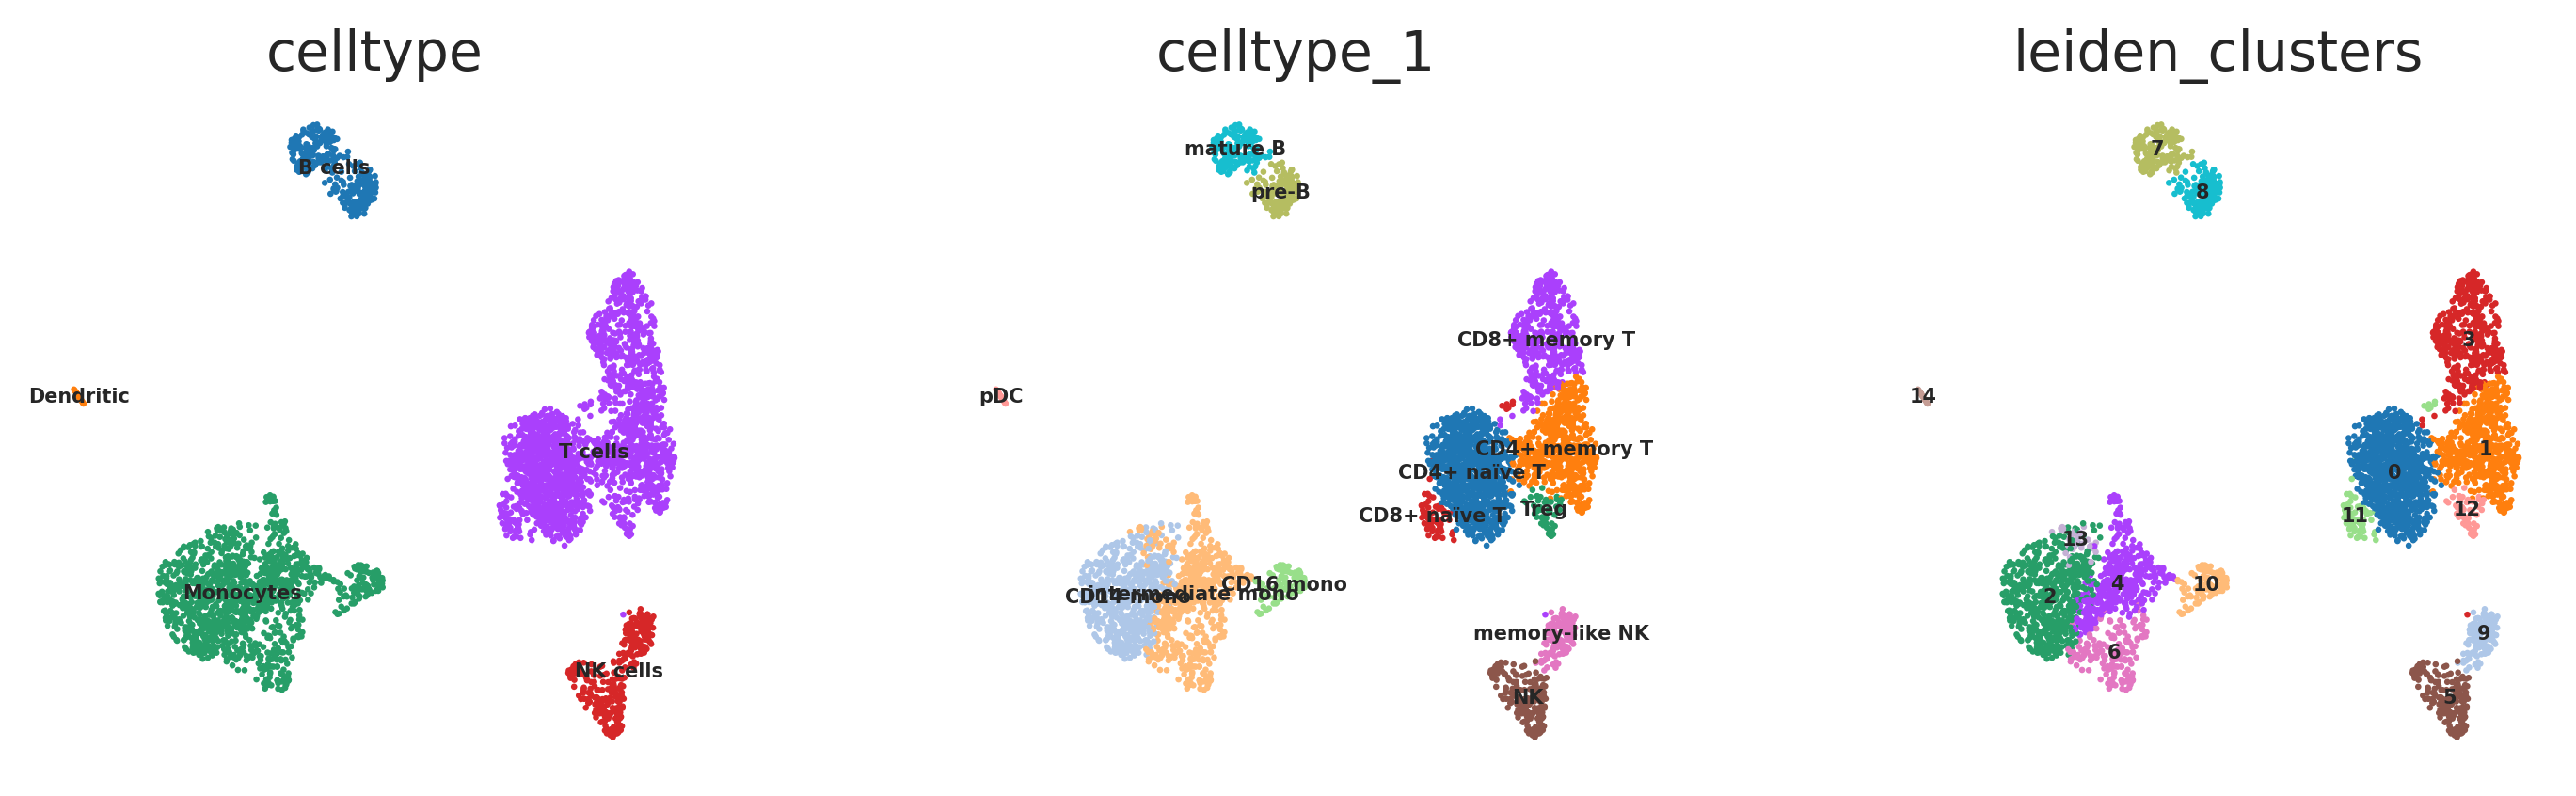

In [20]:
sc.settings.set_figure_params(dpi=150,figsize=(3, 3.1))
sc.pl.umap(adata_processed, size=10,color=["celltype", "celltype_1", "leiden_clusters"],color_map="viridis",legend_loc="on data", frameon=False, legend_fontsize=5) #legend_loc="right margin", 

In [9]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', #'CD29', 
                'FOXP3', 'IL2RA',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7', 'KLRC2',
                'CD79A', 'MS4A1', 'TCL1A', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'IRF8', 'TCF4']

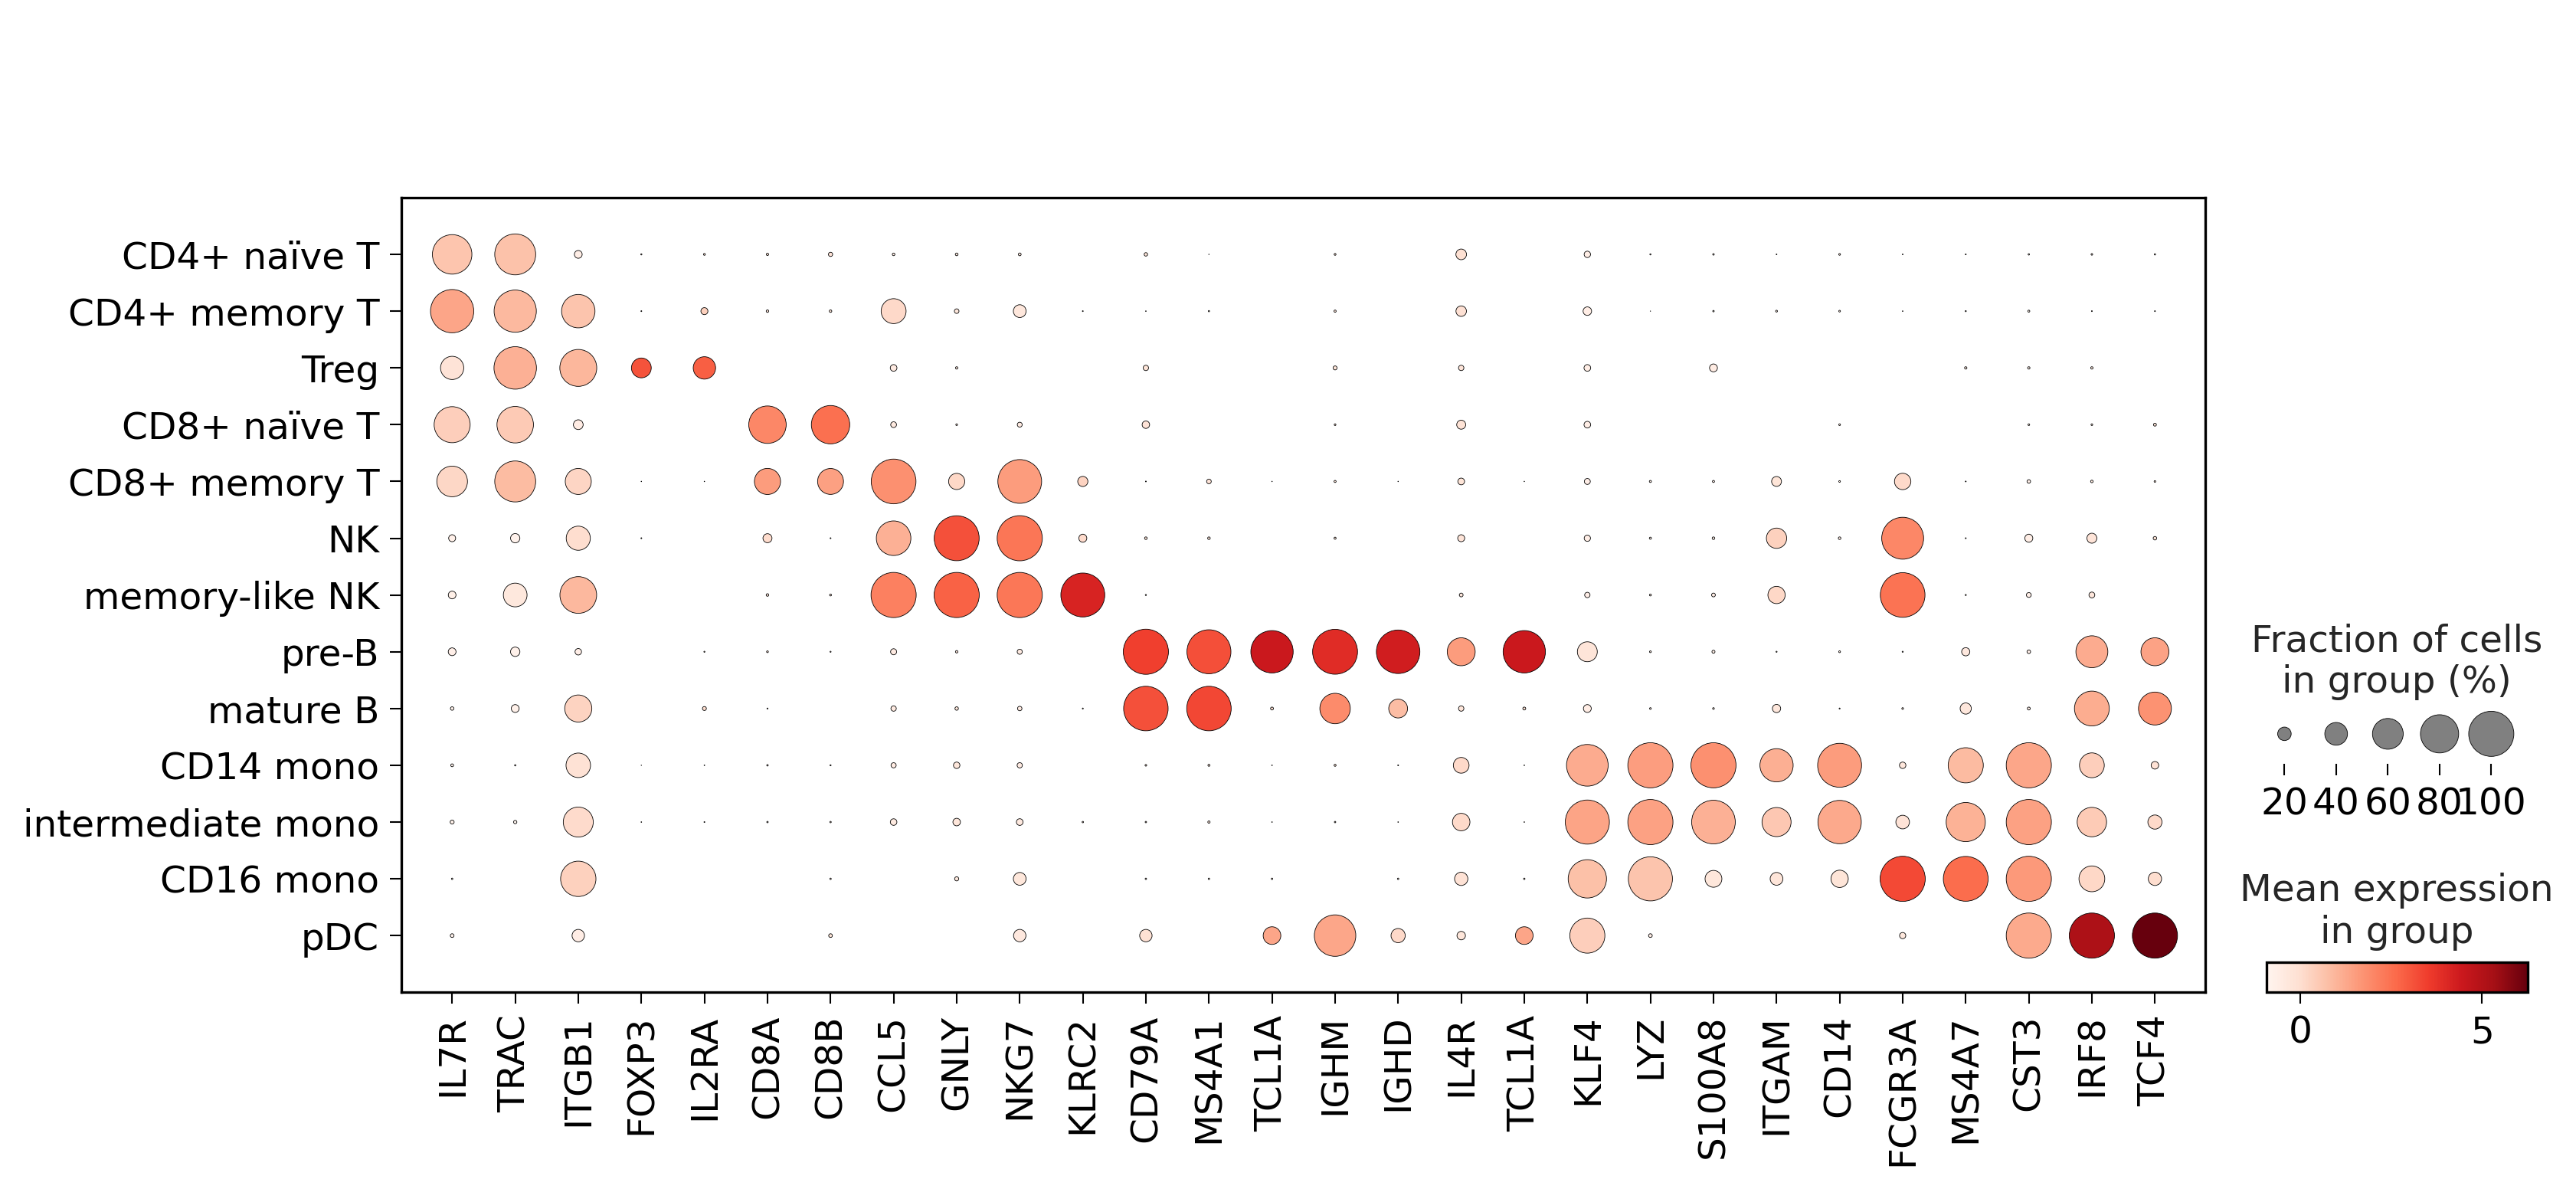

In [22]:
sc.pl.dotplot(adata_processed, marker_genes, groupby='celltype_1');

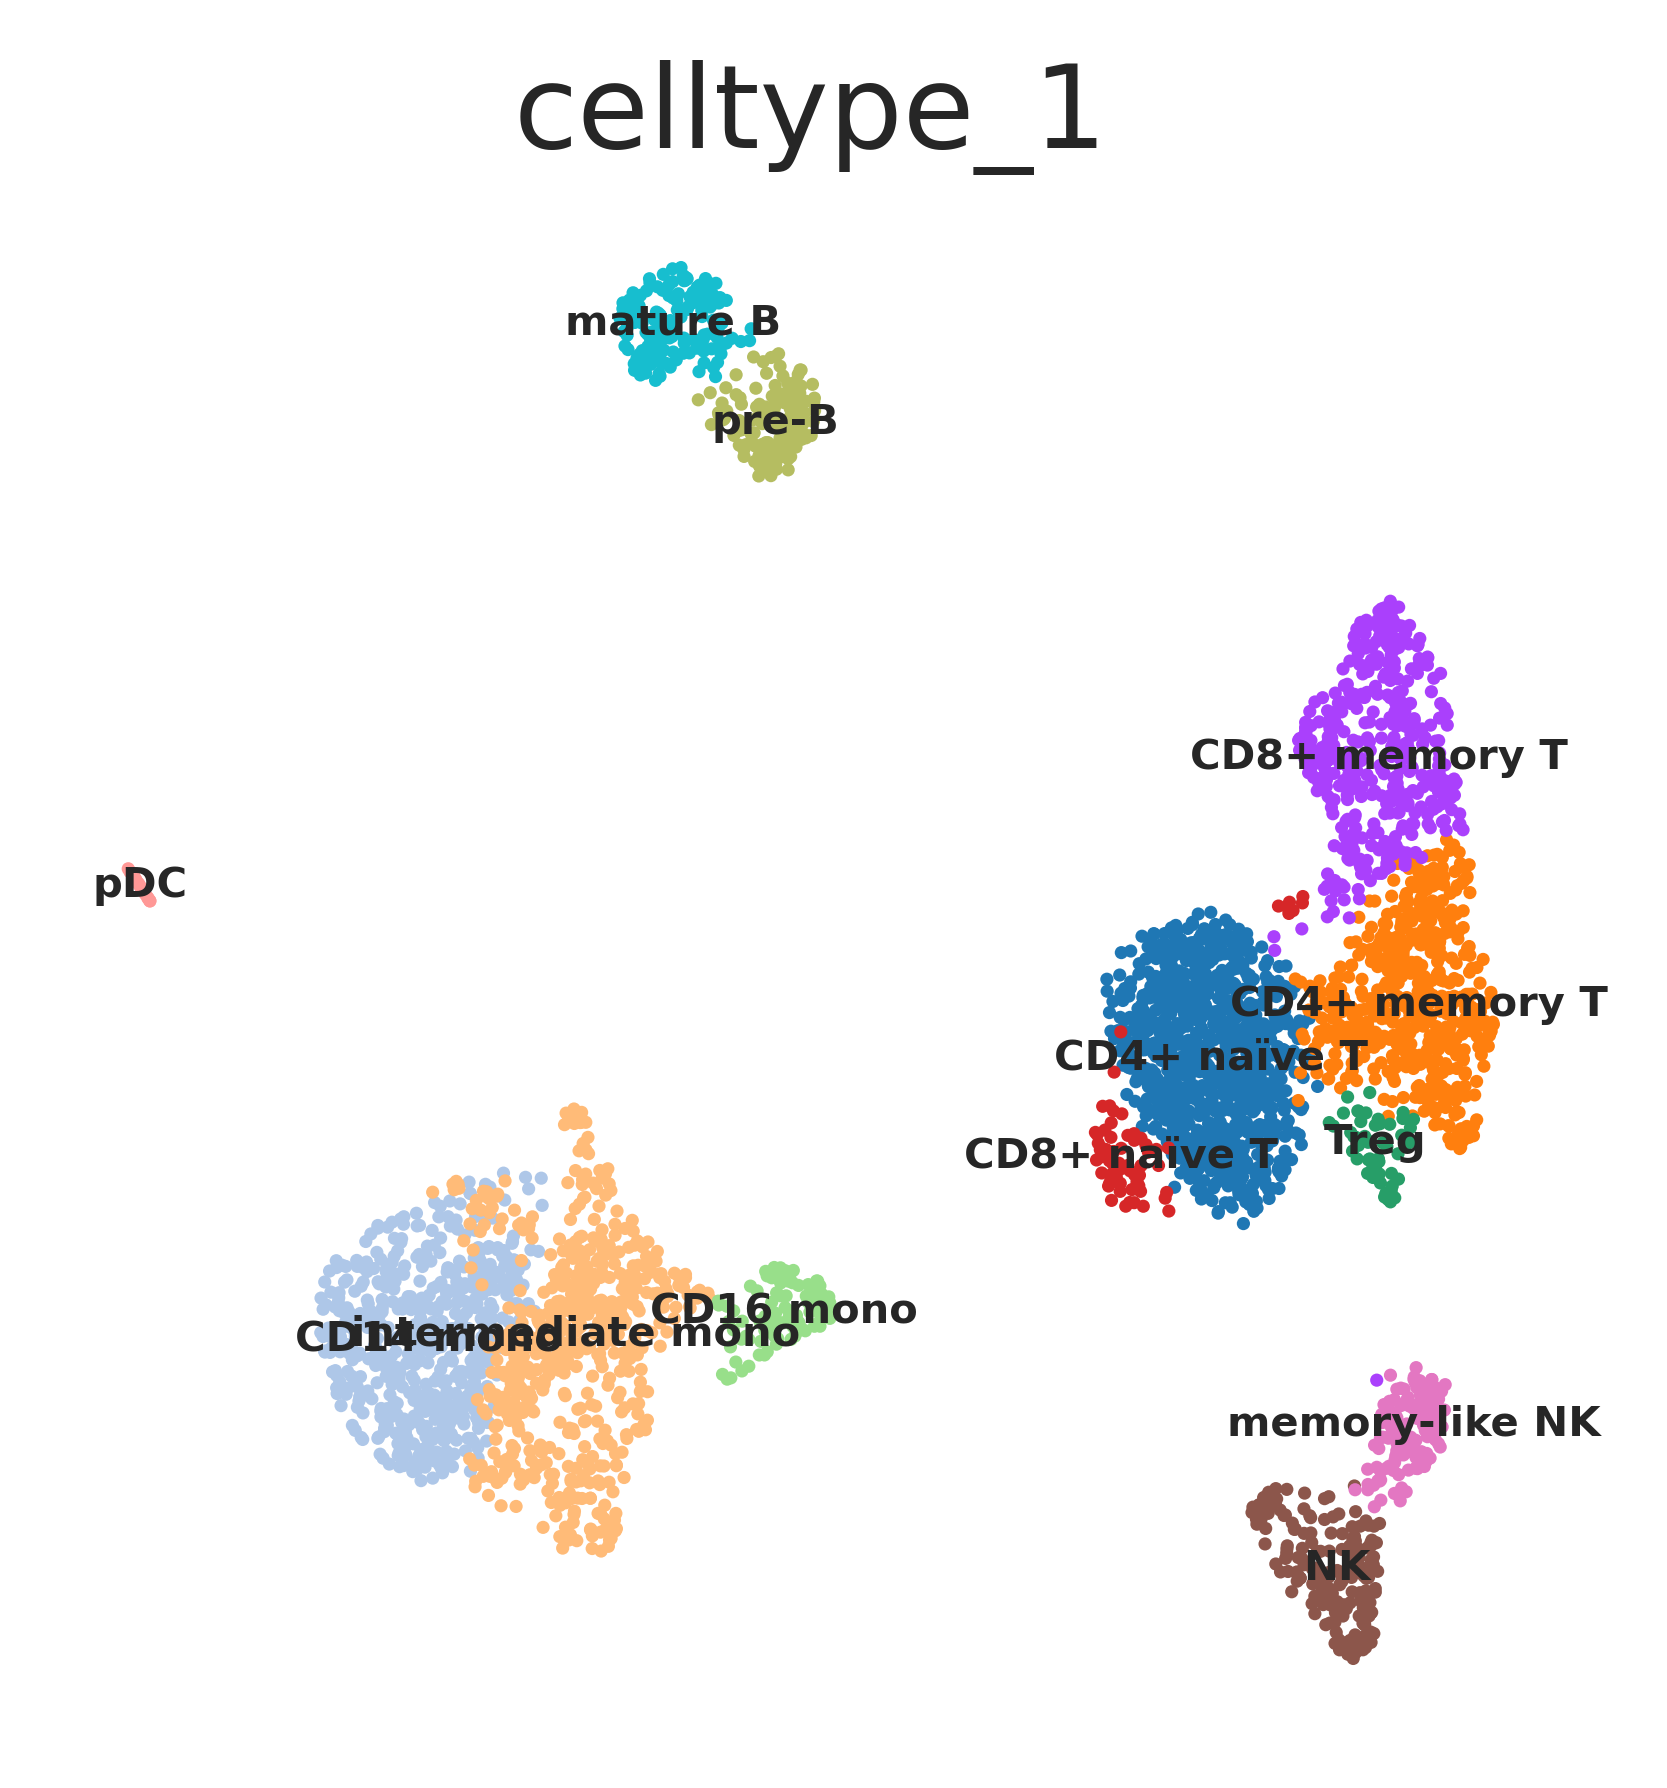

In [144]:
sc.settings.set_figure_params(dpi=300,figsize=(3, 3.2))
ax = sc.pl.umap(adata_processed, size=10, color=["celltype_1"],
                frameon=False,
                legend_loc="on data", legend_fontsize=5,
                vmax=3, vmin=0,  save='CITEseq_5k_PBMCs_protein_celltype.pdf', return_fig=False) #legend_loc="right margin",vcenter=0.5,

In [24]:
marker_list = []
for ct, mg in marker_genes_dict.items():
    if type(mg) is str:
        mg = [mg]
    marker_list.extend(mg)

In [10]:
fb_filtered.columns = fb_filtered.columns.str.replace('_TotalSeqB', '_raw')
denoised_fb_filtered.columns = denoised_fb_filtered.columns.str.replace('_TotalSeqB', '_scar')

fb_filtered1 = np.log2(fb_filtered+1)
denoised_fb_filtered1 = np.log2(denoised_fb_filtered+1)

In [11]:
mRNA_list = {'CD86': 'CD86',
            'CD274': 'CD274',
            'CD8a': 'CD8A',
            'CD56': 'CD56',
            'CD19': 'CD19',
            'CD45RA': 'PTPRC',
            'CD4': 'CD4',
            'CD14': 'CD14',
            'CD16': 'FCGR3A',
            'CD25': 'IL2RA',
            'CD45RO': 'PTPRC',
            'TIGIT': 'TIGIT',
            'CD20': 'MS4A1',
            'CD335': 'NCR1',
            'CD69': 'CD69',
            'CD62L': 'SELL',
             'CD197': 'CCR7',
            'CD27': 'CD27',
            'HLA-DR': 'HLA-DRA',
            'CD278': 'ICOS',
            'CD137': 'TNFRSF9',
            'CD28': 'CD28',
            'CD127': 'IL7R',
            'CD86': 'CD86',
            'CD274': 'CD274',
            'CD3': 'CD3D',
            'CD56': 'NCAM1',
            'CD19': 'CD19',
            'CD11b': 'ITGAM',
            'CD15': 'FUT4',
            'CD20': 'CCR7',
            'CD34': 'CD34',
            'CD80': 'CD80',
            'PD-1': 'PDCD1',
            'IgG1_control': 'IGHG1',
            'IgG2a_control': 'IGHG2',
            'IgG2b_control': 'IGHG2',
            }

for key in fb_filtered.columns.str.replace('_raw', ''):
    mRNA_list[key] = mRNA_list.pop(key)

In [ ]:
for gene in set(mRNA_list.values()):
    if (gene in adata.var_names) and (gene not in adata_processed.var_names):
        print(gene, ' filtered out')
    if (gene not in adata.var_names) and (gene not in adata_processed.var_names):
        print(gene, ' wrong name')

In [ ]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp, target_sum=1e4)
mRNA = adata_tmp[:, list(set(mRNA_list.values()))][adata_processed.obs.index].to_df()

In [29]:
mRNA = np.log2(mRNA + 1)
adata_processed.obs = adata_processed.obs.join(mRNA, how ='left').join(fb_filtered1, how='left').join(denoised_fb_filtered1, how='left')

In [30]:
sorted_idx = adata_processed.obs.sort_values('celltype_1').index
adata_processed = adata_processed[sorted_idx]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [30]:
adata_processed.write('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CITEseq_5k_PBMCs/processed_adata_20_11_2021.h5ad')

In [13]:
adata_processed = sc.read('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CITEseq_5k_PBMCs/processed_adata_20_11_2021.h5ad')